# **[IntoAI] WEEK6 : Decision Tree**

### **목차**
1. 결정 트리 학습과 시각화
2. 예측하기
3. 클래스 확률 추정
4. 규제 매개변수
5. 회귀

*핸즈온 머신러닝(제2판)* 도서를 기반으로 작성되었으며 https://github.com/rickiepark/handson-ml2 을 참고하였습니다.
* 코드와 이론에 대한 자세한 설명은 (블로그 링크)를 참고하세요.
* **Google Colab**을 기반으로 작동하도록 제작되었습니다.

### **0. 기본 환경 세팅**

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### **1. 결정 트리 학습과 시각화** 

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비 - 우선은 2개의 특성만 사용해봅시다
y = iris.target

# DecisionTreeClassifier를 사이킷런에서 불러와서 사용해줍니다.
# 각 매개 변수는 트리의 깊이, 랜덤 여부입니다.
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**<그림 6-1. 붓꽃 결정 트리> 생성 코드**

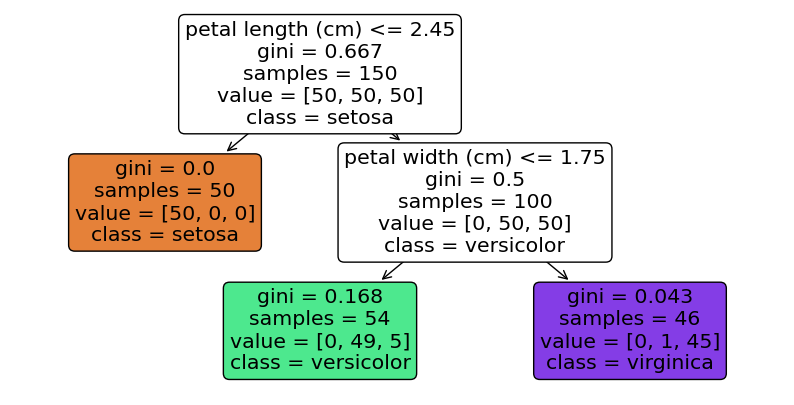

In [3]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,5))
# rounded는 박스의 모서리가 둥글게. filled는 클래스별로 박스의 색을 다르게 채워준다.
plot_tree(tree_clf, rounded=True, filled=True, feature_names=iris.feature_names[2:], class_names=iris.target_names, max_depth=2)

plt.show()

1번째 노드 : 꽃잎의 길이가 2.45보다 작으면 왼쪽으로 그렇지 않으면 오른쪽으로 분기       
왼쪽 주황색 노드 : setosa로 분류된 것만 50개        
오른쪽 흰색 노드 : 꽃잎의 너비가 1.75보다 작으면 왼쪽으로 그렇지 않으면 오른쪽으로 분기 / versicolor와 virginica로 분류된 것들이 입력되게 된다.     
마지막 두 노드 : versicolor와 virginica로 완벽하게 분류가 되지는 않았지만 다수의 class로 class를 결정       

### **2. 예측하기**

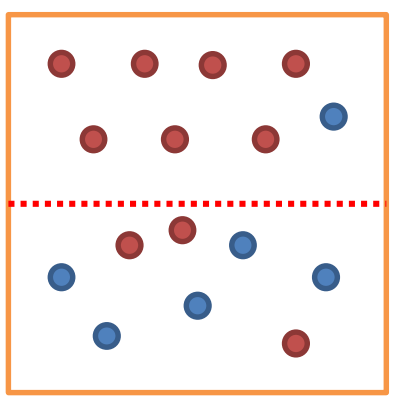

**식 6-1: 지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

* p_{i,k}는 i번째 노드에 있는 k클래스의 비율  
* 예를들어서 초록색 노드를 보면,  1-((0/54))^2 + ((49/54))^2 + ((5/54))^2
* 이러한 불순도가 최소가 될 수 있도록 노드를 분할하기!

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$

* **모든 불순도는 criterion 매개변수를 통해서 설정이 가능하다**

**식 6-2: 분류에 대한 CART 비용 함수**    

![image.png](attachment:image.png)

**<그림 6-2. 결정 트리의 결정 경계> 생성 코드**

그림 저장: decision_tree_decision_boundaries_plot


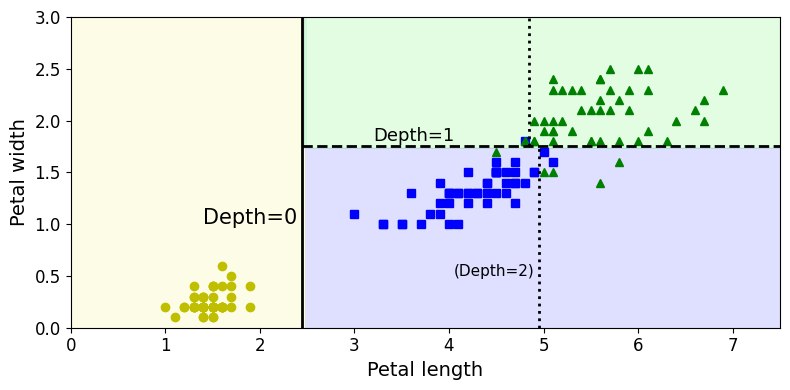

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
# 결정경계 그리기
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

### **3. 클래스 확률 추정**

In [14]:
tree_clf.predict_proba([[2, 0.5]])

array([[1., 0., 0.]])

In [15]:
tree_clf.predict([[5, 1.5]])

array([1])

### **4. 규제 매개변수**

**<그림 6-3. min_samples_leaf 매개변수를 사용한 규제> 생성 코드**

* leaf node가 될 최소 샘플의 개수
* 어떠한 노드가 분할을 했는데 min_samples_leaf 보다 자식노드의 샘플의 개수가 작아지면 분할을 하지 않고 현재상태에서 정지한다.
* 과적합을 방지할 수 있다.

그림 저장: min_samples_leaf_plot


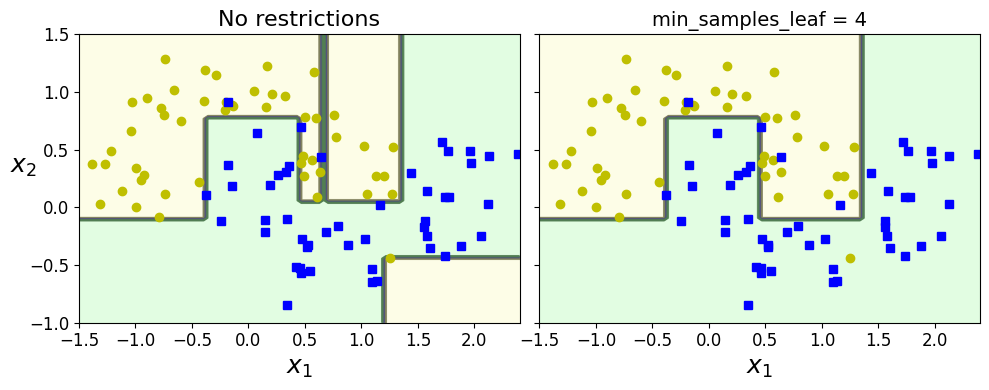

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

### **5. 회귀**

간단한 선형 데이터셋을 준비합니다:

In [16]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

**코드 예제:**

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

**<그림 6-5. 두 개의 결정 트리 회귀 모델의 예측> 생성 코드**

그림 저장: tree_regression_plot


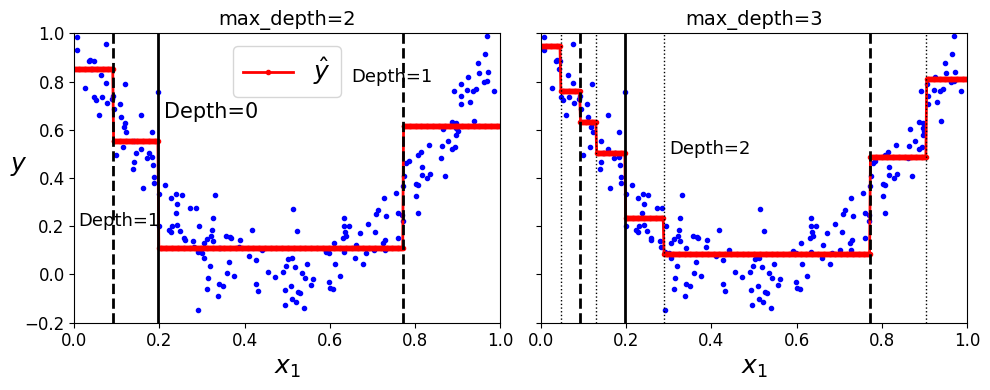

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

**<그림 6-4. 회귀 결정 트리> 생성 코드**

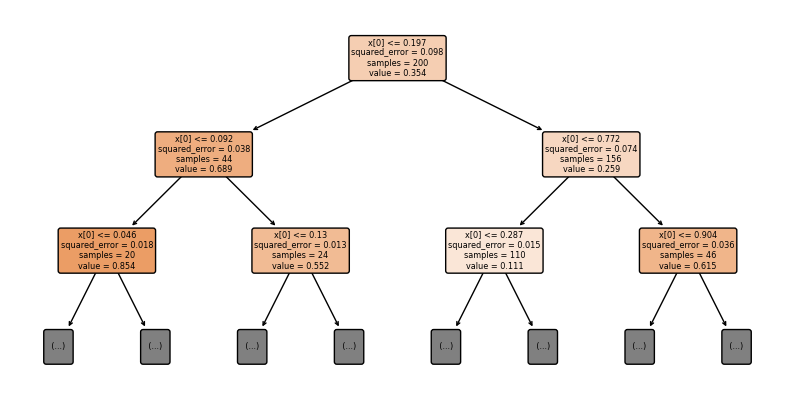

In [17]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,5))
plot_tree(tree_reg1, rounded=True, filled=True, max_depth=2)

plt.show()

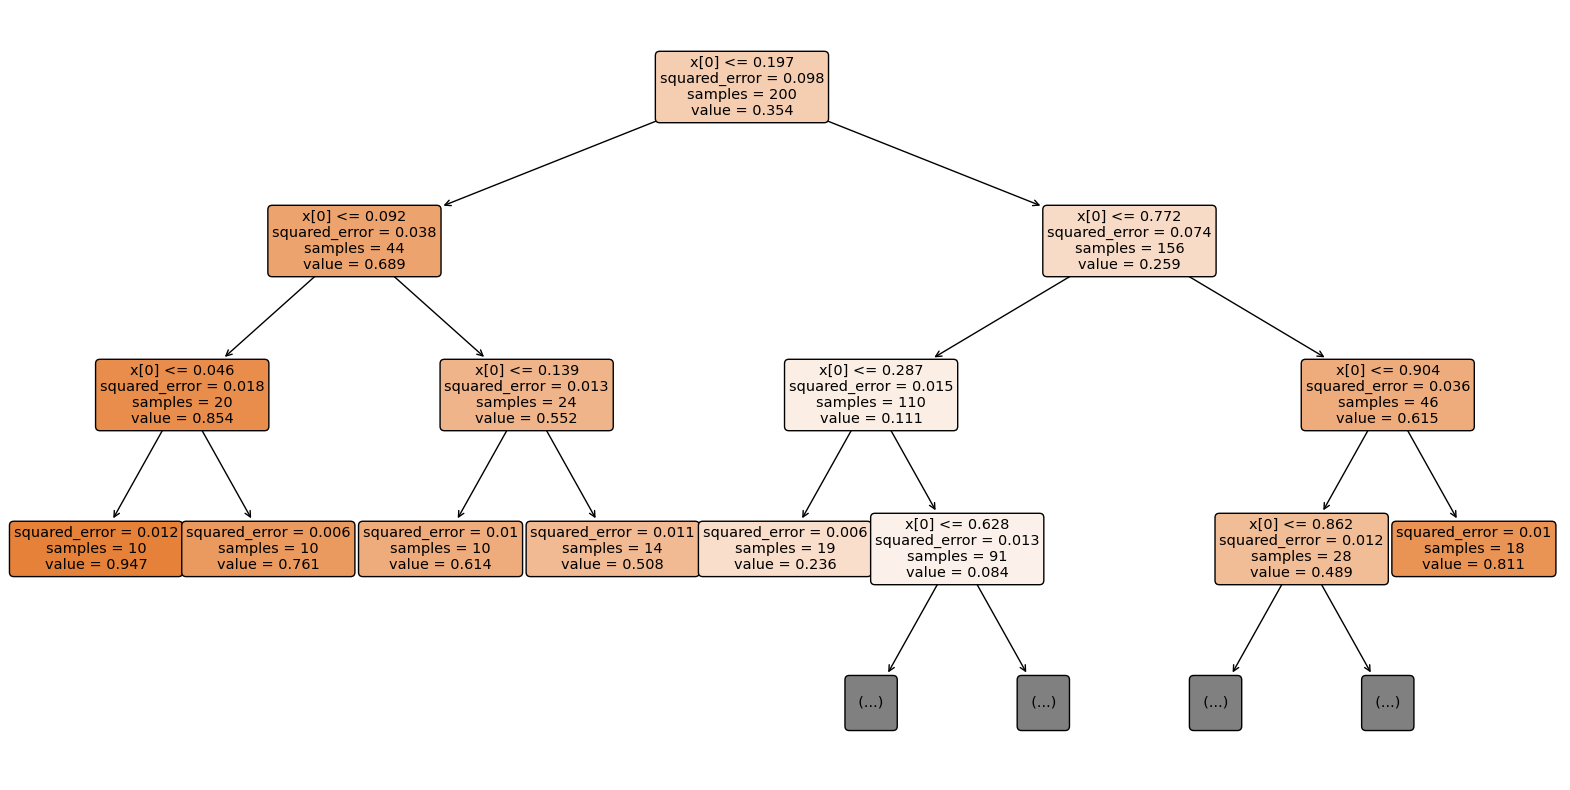

In [19]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree_reg2, rounded=True, filled=True, max_depth=3)

plt.show()

**<그림 6-6. 결정 트리 회귀 모델의 규제> 생성 코드**

그림 저장: tree_regression_regularization_plot


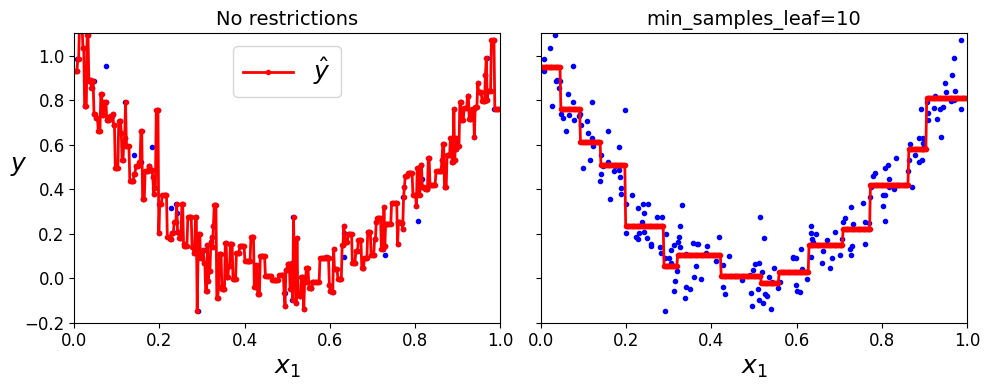

In [13]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

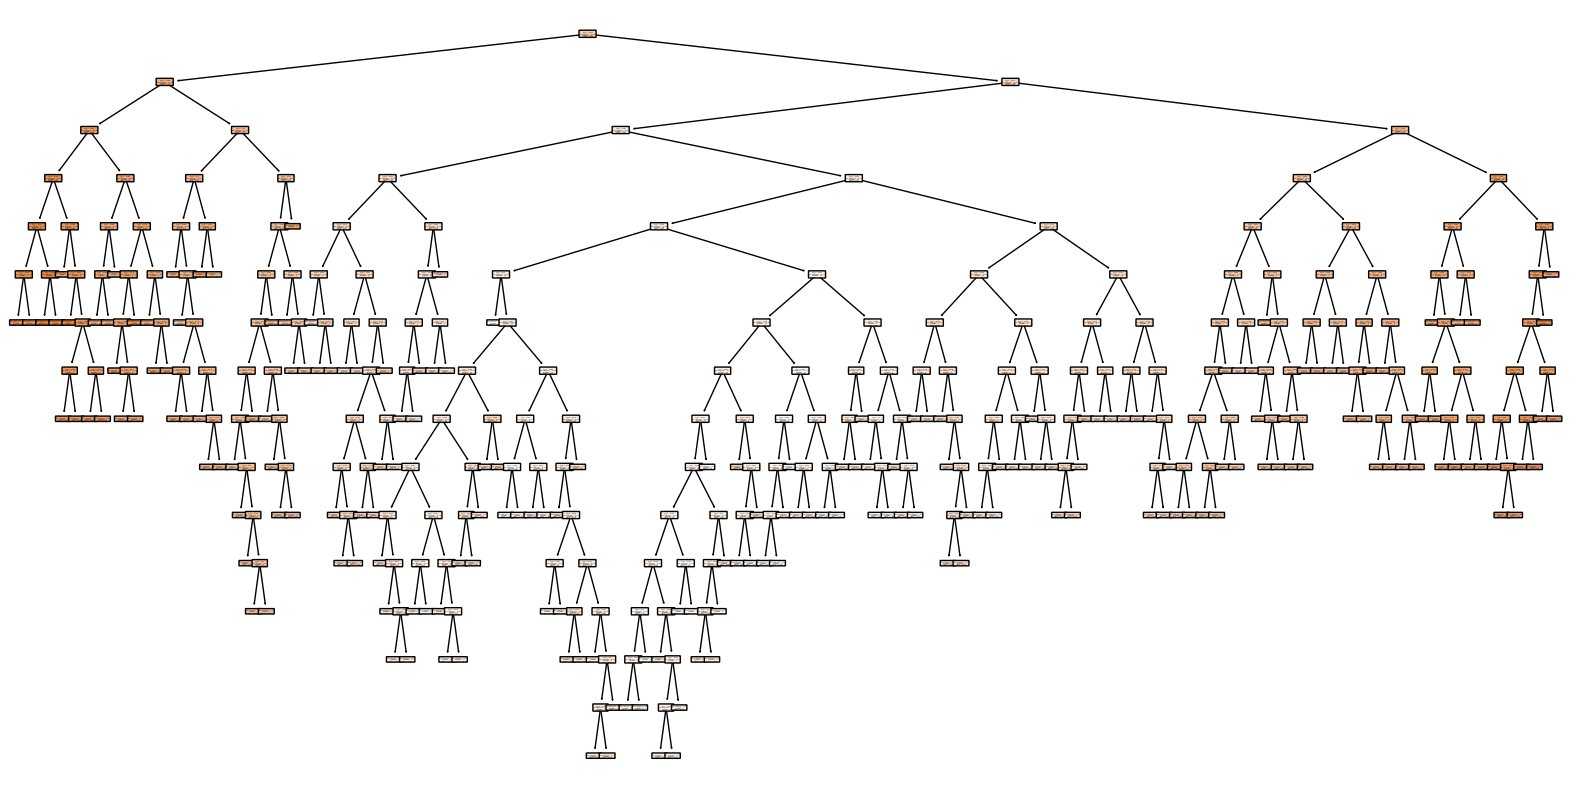

In [22]:
plt.figure(figsize=(20,10))
plot_tree(tree_reg1, rounded=True, filled=True, max_depth=None)

plt.show()

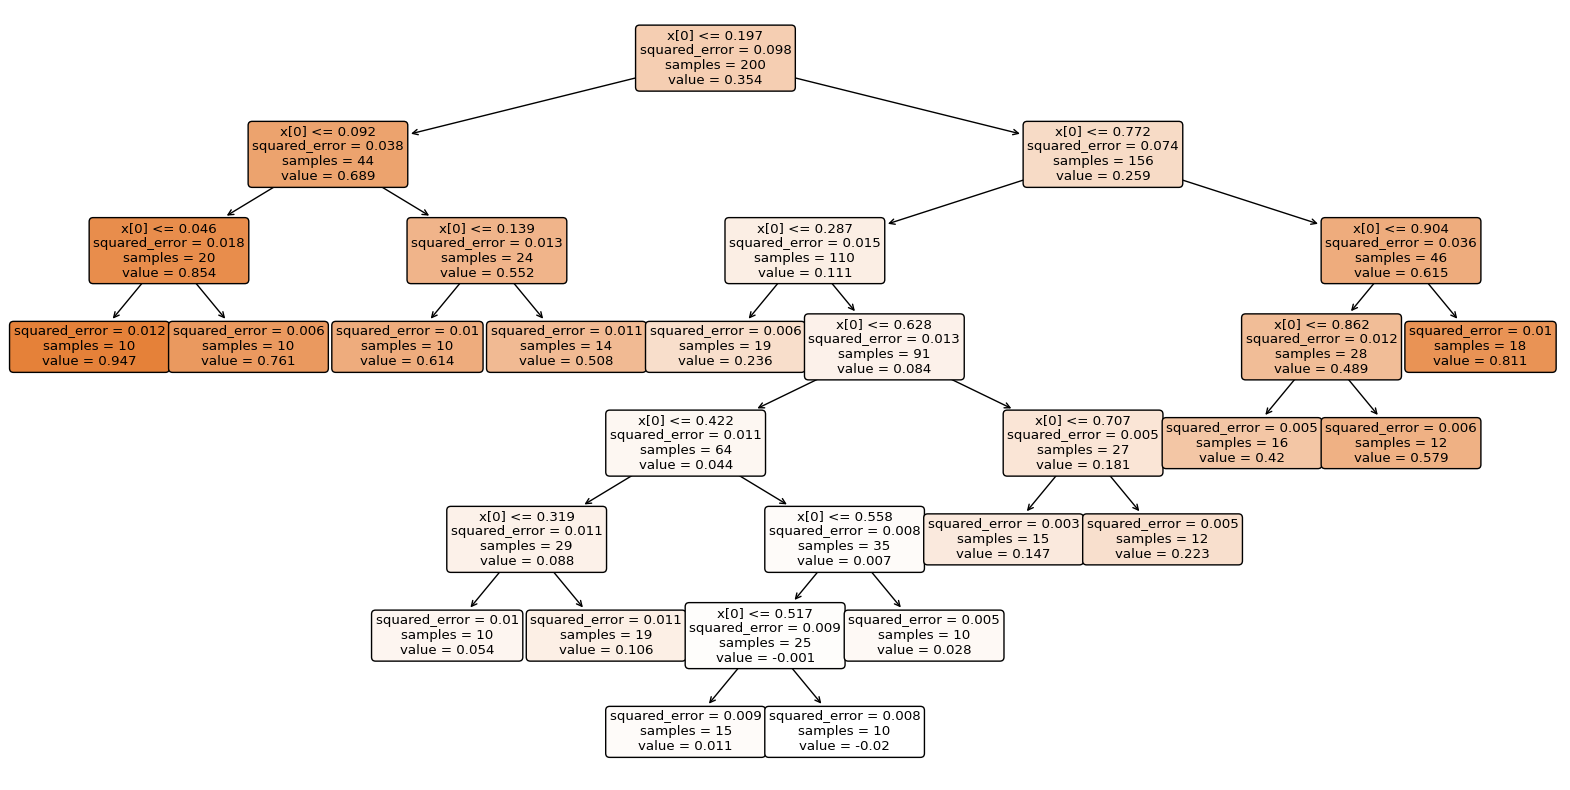

In [23]:
plt.figure(figsize=(20,10))
plot_tree(tree_reg2, rounded=True, filled=True, max_depth=10)

plt.show()